In [1]:
import cv2
import os
import time
import copy
import glob
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

import numpy as np

In [2]:
data_path = './data/catanddog/train'

transform = transforms.Compose([
    transforms.Resize([256,256]),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.ImageFolder(data_path, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, num_workers=8, shuffle=True)

print(len(train_dataset))

385


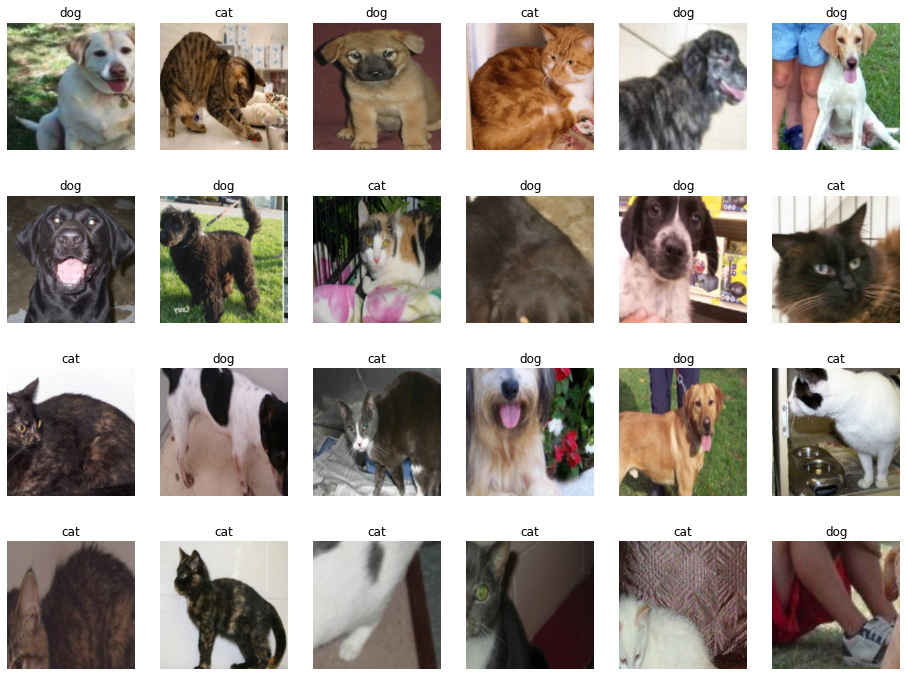

In [3]:
samples, labels = next(iter(train_loader))
classes = {0:'cat' , 1:'dog'}

fig = plt.figure(figsize=(16,24))

for i in range(24):
    a = fig.add_subplot(4, 6, i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))

plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [4]:
resnet18 = models.resnet18(pretrained=True)

c:\Users\USER\anaconda3\envs\book_01\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\USER\anaconda3\envs\book_01\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [6]:
set_parameter_requires_grad(resnet18)

In [7]:
resnet18.fc = nn.Linear(512, 2)

In [8]:
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data, len(param.data))

fc.weight tensor([[ 0.0018, -0.0436,  0.0331,  ..., -0.0024,  0.0037, -0.0100],
        [ 0.0151, -0.0438, -0.0054,  ..., -0.0003, -0.0196, -0.0152]]) 2
fc.bias tensor([0.0086, 0.0178]) 2


In [9]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(512, 2)

for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
example = torch.randn(1, 2)
example

tensor([[-0.1092, -0.5269]])

In [11]:
a, pred = torch.max(example, 1)

print(a, pred)

tensor([-0.1092]) tensor([0])


In [12]:
for inputs, labels in train_loader:
    ipt = inputs[0]
    lbl = labels[0]

In [13]:
lbl

tensor(1)

In [14]:
ipts = torch.tensor([32, 3, 224, 224])
ipts.size(0)

4

In [15]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs = 13, is_train = True):
    since = time.time()
    acc_history = []
    loss_history = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('LOSS: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join('./data/catanddog/', '{0:0=2d}.pth'.format(epoch)))
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    return acc_history, loss_history

In [16]:
params_to_update = []

for name, param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print('\t', name)

optimizer = optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [18]:
torch.__version__

'1.13.1'

In [19]:
criterion = nn.CrossEntropyLoss()

trian_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------
LOSS: 0.6400 Acc: 0.6312

Epoch 1/12
----------
LOSS: 0.4003 Acc: 0.8571

Epoch 2/12
----------
LOSS: 0.3170 Acc: 0.8987

Epoch 3/12
----------
LOSS: 0.2791 Acc: 0.8883

Epoch 4/12
----------
LOSS: 0.2088 Acc: 0.9532

Epoch 5/12
----------
LOSS: 0.2362 Acc: 0.9195

Epoch 6/12
----------
LOSS: 0.2733 Acc: 0.8805

Epoch 7/12
----------
LOSS: 0.2814 Acc: 0.8571

Epoch 8/12
----------
LOSS: 0.3267 Acc: 0.8494

Epoch 9/12
----------
LOSS: 0.3173 Acc: 0.8364

Epoch 10/12
----------
LOSS: 0.1979 Acc: 0.9091

Epoch 11/12
----------
LOSS: 0.1767 Acc: 0.9403

Epoch 12/12
----------
LOSS: 0.1911 Acc: 0.9143

Training complete in 0m 42s
Best Acc: 0.953247


In [20]:
test_path = './data/catanddog/test'

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

test_dataset = torchvision.datasets.ImageFolder(root=test_path, transform=transform)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = 32,
    num_workers = 1,
    shuffle = True
)

print(len(test_dataset))

98


In [21]:
def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('./data/catanddog/' + '*.pth')
    saved_models.sort()
    print('saved_model' , saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels.to(device)).int().sum()

        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))

    return acc_history

In [22]:
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['./data/catanddog\\00.pth', './data/catanddog\\01.pth', './data/catanddog\\02.pth', './data/catanddog\\03.pth', './data/catanddog\\04.pth', './data/catanddog\\05.pth', './data/catanddog\\06.pth', './data/catanddog\\07.pth', './data/catanddog\\08.pth', './data/catanddog\\09.pth', './data/catanddog\\10.pth', './data/catanddog\\11.pth', './data/catanddog\\12.pth']
Loading model ./data/catanddog\00.pth
Acc: 0.8469

Loading model ./data/catanddog\01.pth
Acc: 0.9388

Loading model ./data/catanddog\02.pth
Acc: 0.9082

Loading model ./data/catanddog\03.pth
Acc: 0.9082

Loading model ./data/catanddog\04.pth
Acc: 0.9490

Loading model ./data/catanddog\05.pth
Acc: 0.9286

Loading model ./data/catanddog\06.pth
Acc: 0.9286

Loading model ./data/catanddog\07.pth
Acc: 0.9490

Loading model ./data/catanddog\08.pth
Acc: 0.9184

Loading model ./data/catanddog\09.pth
Acc: 0.9286

Loading model ./data/catanddog\10.pth
Acc: 0.9082

Loading model ./data/catanddog\11.pth
Acc: 0.9388

Loading mod

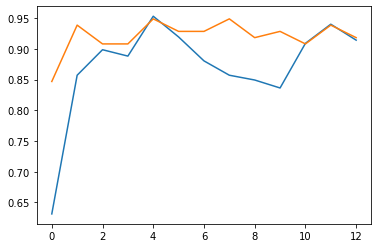

In [23]:
plt.plot(trian_acc_hist)
plt.plot(val_acc_hist)
plt.show()

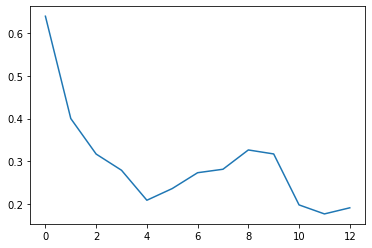

In [24]:
plt.plot(train_loss_hist)
plt.show()

In [25]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1,2,0)
    image = image * (np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5)))
    image = image.clip(0,1)
    return image

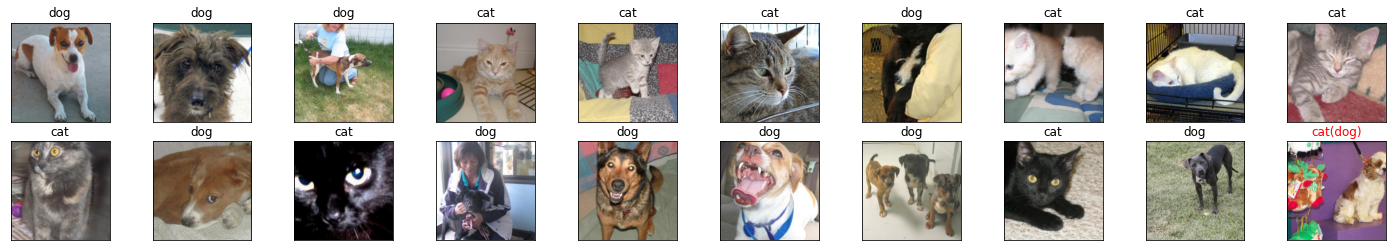

<Figure size 432x288 with 0 Axes>

In [26]:
classes = {0:'cat' , 1:'dog'}

dataiter = iter(test_loader)
images, labels = next(dataiter)

output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize = (25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

ax.set_title('{}({})'.format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color = ('green' if preds[idx] == labels[idx] else 'red'))

plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)